## Where everything comes from

Data were collected on April 22, 2020. The source files can be found on the Google Drive:

   * Our raw data: **penn-2020-04-22/PrincetonFlowMeter_simtest.out**
   * NM3 data: **penn-2020-04-22/200422_princetonmonitor.txt**
   * ASL data: **ASL Files/***

Our timeseries data, **penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv**, were derived using

```bash
./device_json_to_timeseries.py penn-2020-04-22/PrincetonFlowMeter_simtest.out --start-time-at-zero > penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv
```

Our breaths data, **penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv**, were derived using

```bash
./timeseries_to_breaths.py penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv > penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv
```

In [54]:
import re
import string
import json

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.integrate
import pandas as pd
import iminuit

## Reading in our data

In [2]:
our_timeseries = pd.read_csv("../penn-2020-04-22/PrincetonFlowMeter_simtest_timeseries.csv")
our_timeseries.columns = our_timeseries.columns.str.strip()
our_timeseries

,time (sec),pressure (cm H2O),flow (L/min),volume (mL),minbias volume (mL)
0,0.000,-0.2040,-0.0971,335.3869,632.2089
1,0.020,-0.1749,0.2904,335.4189,632.2411
2,0.040,-0.1615,0.1939,335.4987,632.3217
3,0.060,-0.1962,0.0000,335.5294,632.3539
4,0.080,-0.1898,0.2904,335.5758,632.4021
...,...,...,...,...,...
140440,2813.227,-0.0410,0.3865,340.9751,686.5913
140441,2813.247,-0.0371,0.1939,341.0014,686.6197
140442,2813.267,-0.0615,0.0000,340.9634,686.5837
140443,2813.287,-0.0142,0.3865,340.9578,686.5798


In [3]:
our_breaths = pd.read_csv("../penn-2020-04-22/PrincetonFlowMeter_simtest_breaths.csv")
our_breaths.columns = our_breaths.columns.str.strip()
for col in our_breaths.columns:
    our_breaths[col] = our_breaths[col].astype(float)
our_breaths

,inhale timestamp (sec),inhale flow (L/min),inhale dV/dt (mL/sec),inhale dP/dt (cm H2O/sec),inhale compliance (ml/cm H2O),min pressure (cm H2O),full timestamp (sec),full pressure (cm H2O),full volume (mL),expiratory tidal volume (mL),...,exhale dP/dT (cm H2O/sec),exhale compliance (ml/cm H2O),max pressure (cm H2O),empty timestamp (sec),empty pressure (cm H2O),empty volume (mL),exhale time (sec),average flow (L/min),average pressure (cm H2O),time since last (sec)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.304000,-0.1812,684.1496,NaN,NaN,NaN,NaN
1,40.764000,34.7643,143.044867,2.580221,55.438997,NaN,41.044000,0.5228,768.4770,84.3274,...,-1.536830,68.318962,7.8072,44.305000,-0.5316,680.5836,3.261000,0.184030,-0.236357,4.001000
2,44.825000,34.6703,278.890419,4.670678,59.710912,-1.2160,45.185000,-1.3128,829.8532,149.2696,...,-1.552648,69.734822,8.4128,48.307000,-0.1457,727.4864,3.122000,1.123753,0.321197,4.002000
3,48.847044,36.9575,299.799024,3.662988,81.845475,-0.6198,49.187067,-0.7789,887.3416,159.8552,...,-1.872082,65.455667,9.2216,52.289000,0.0897,753.3311,3.101933,0.958570,0.633443,3.982000
4,52.869078,39.1641,346.319899,1.829615,189.285668,-0.2836,53.229844,-0.4096,939.2876,185.9565,...,-2.326864,62.789128,10.3067,56.295900,0.3653,772.8681,3.066056,0.978593,1.016081,4.006900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,2614.926000,35.1752,533.445134,7.196724,74.123329,8.3151,2615.546000,20.3182,1036.4319,455.2573,...,-7.707564,52.186288,20.3607,2618.207000,10.2185,557.7655,2.661000,-0.005159,13.159128,3.941000
643,2618.887000,38.1000,550.642529,7.461725,73.795611,8.3285,2619.547000,20.3261,1047.8469,490.0814,...,-8.353320,46.984859,20.3261,2622.187022,10.0240,570.8478,2.640022,0.572923,13.165398,3.980022
644,2622.909800,45.8599,689.262323,9.440785,73.009002,8.4128,2623.674678,25.6717,1203.1997,632.3519,...,-10.671542,44.756261,25.7536,2634.565000,8.4569,579.0608,10.890322,0.066102,11.036932,12.377978
645,2635.325000,38.3251,579.906811,12.831069,45.195517,8.4419,2636.265722,24.1817,1167.4047,588.3439,...,-8.764647,46.126071,24.2793,2646.584133,9.0711,644.6826,10.318411,0.628826,11.436904,12.019133


## Reading in the NM3 data

In [4]:
def read_nm3(filename):
    with open(filename) as file:
        for i, line in enumerate(file):
            if i == 8:
                break

        time, pressure, flow = [], [], []
        for line in file:
            row = line.strip().split()
            time.append(float(row[0]))
            pressure.append(float(row[2]))
            flow.append(float(row[3]))

        return {"time (sec)": np.array(time), "pressure (cm H20)": np.array(pressure), "flow (L/min)": np.array(flow)}

In [5]:
nm3_timeseries = pd.DataFrame(read_nm3("../penn-2020-04-22/200422_princetonmonitor.txt"))
nm3_timeseries

,time (sec),pressure (cm H20),flow (L/min)
0,39078.5764,-1.165036,-2.176782
1,39078.5774,-1.165036,-2.073890
2,39078.5784,-1.165036,-2.365417
3,39078.5794,-1.165036,-2.108187
4,39078.5804,-1.165036,-1.816660
...,...,...,...
2720995,41799.5714,-0.142530,-1.885255
2720996,41799.5724,-0.142530,-2.125336
2720997,41799.5734,-0.142530,-2.622647
2720998,41799.5744,-0.142530,-2.176782


## Reading in the ASL data

In [6]:
def asl2numpy(filename, numcolumns=None):
    with open(filename, "rb") as file:
        headerbytes = None
        for line in file:
            if re.search(rb"column", line, re.I):
                break
            m = re.search(rb"([0-9]+) byte header", line)
            if m is not None:
                headerbytes = int(m.group(1))

        columns = []
        for line in file:
            column = line.strip()
            if len(column) != 0 and all(x in string.printable.encode() for x in column):
                columns.append(column)
            elif len(columns) != 0:
                break

        if numcolumns is not None:
            columns = columns[:numcolumns]
            columns = columns + [b"unknown %d" % i for i in range(numcolumns - len(columns))]

        file.seek(0)
        return np.frombuffer(file.read()[headerbytes:], dtype=">f4").astype("<f4").view([(x.decode(), "<f4") for x in columns])

In [7]:
asl_timeseries = pd.DataFrame(asl2numpy("../ASL Files/Princeton2020_1.rwb"))
asl_timeseries

,Time (sec),Airway Pressure (cmH2O),Muscle Pressure (cmH2O),Tracheal Pressure (cmH2O),Chamber 1 Volume (L),Chamber 2 Volume (L),Total Volume (L),Chamber 1 Pressure (cmH2O),Chamber 2 Pressure (cmH2O),Breath File Number (#),Aux 1 (V),Aux 2 (V),Oxygen Sensor (V)
0,194.455078,6.324864,0.000763,7.378500,0.184478,0.184478,0.369077,7.378500,7.378500,48.0,4.951477,4.942627,2.545013
1,194.457031,6.331731,0.000763,7.373922,0.184356,0.184356,0.368817,7.373922,7.373922,48.0,4.951477,4.942627,2.545013
2,194.458984,6.338598,0.000763,7.369345,0.184234,0.184234,0.368568,7.369345,7.369345,48.0,4.951477,4.942627,2.545013
3,194.460938,6.345464,0.000763,7.364767,0.184111,0.184111,0.368320,7.364767,7.364767,48.0,4.951477,4.942627,2.545013
4,194.462891,6.334020,0.000763,7.360189,0.183990,0.183990,0.368084,7.360189,7.360189,48.0,4.969482,4.951477,2.545319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867555,3842.023438,0.659953,0.000763,0.647745,0.012982,0.012982,0.025971,0.647745,0.647745,942.0,4.904327,4.887695,2.366943
1867556,3842.025391,0.656138,0.000763,0.647745,0.012982,0.012982,0.025971,0.647745,0.647745,942.0,4.911957,4.891663,2.365417
1867557,3842.027344,0.652323,0.000763,0.647745,0.012982,0.012982,0.025958,0.647745,0.647745,942.0,4.911957,4.891663,2.365417
1867558,3842.029297,0.648508,0.000763,0.647745,0.012982,0.012982,0.025958,0.647745,0.647745,942.0,4.911957,4.891663,2.365417


In [8]:
asl_breaths = pd.DataFrame(asl2numpy("../ASL Files/Princeton2020_1.brb"))
asl_breaths

,Breath Num.,Breath Type,I Time (s),Insp (%),E Time (s),Pause Time (s),Pause (%),Insp Vt (mL),Exp Vt (mL),Ppeak (cmH2O),...,Pressure Filter,Insp Circuit Resistance Setting,Exp Circuit Resistance Setting,Circuit Compliance Setting,Insp Detection Vol Threshold (mL),Exp Detection Vol Threshold (mL),Effort Detection Threshold (cmH2O),Conditions Setting,Peak Exp. Flow (mL/S),P_0.1 (cmH2O)
0,0.0,1.0,1.255859,48.164795,1.351562,0.0,0.0,150.828735,90.231339,0.406653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,-0.130257
1,1.0,0.0,-1.347656,-3631.578857,1.384766,0.0,0.0,90.208977,90.402573,0.192819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.005084
2,2.0,0.0,-1.347656,-3631.578857,1.384766,0.0,0.0,90.210442,90.404045,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.005084
3,3.0,0.0,-1.384766,-723.469360,1.576172,0.0,0.0,90.404045,92.092293,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,0.998148
4,4.0,0.0,-1.576172,-26900.000000,1.582031,0.0,0.0,92.092293,92.108589,0.194603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-144.011749,1.111620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57031,57031.0,0.0,0.003906,33.333332,0.007812,0.0,0.0,0.012911,0.014620,0.649549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.350137,0.000000
57032,57032.0,0.0,0.003906,40.000000,0.005859,0.0,0.0,0.009785,0.004445,0.646289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.368326,0.000000
57033,57033.0,0.0,0.011719,300.000000,-0.007812,0.0,0.0,0.004787,0.003419,0.642960,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000000,0.000000
57034,57034.0,0.0,0.019531,83.333336,0.003906,0.0,0.0,0.006008,0.000537,0.646705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.156880,0.000000


### Derive flow from volume for ASL

Chamber 1 volume and chamber 2 volume are not that different (and I don't know what difference they signify), so I take total volume.

In [9]:
asl_timeseries["flow (L/min)"] = np.gradient(asl_timeseries["Total Volume (L)"] * 1.12, asl_timeseries["Time (sec)"] / 60)

## Overlaying flow to match times

The three plots are early, mid, and late in the session, zoomed in to see breaths.

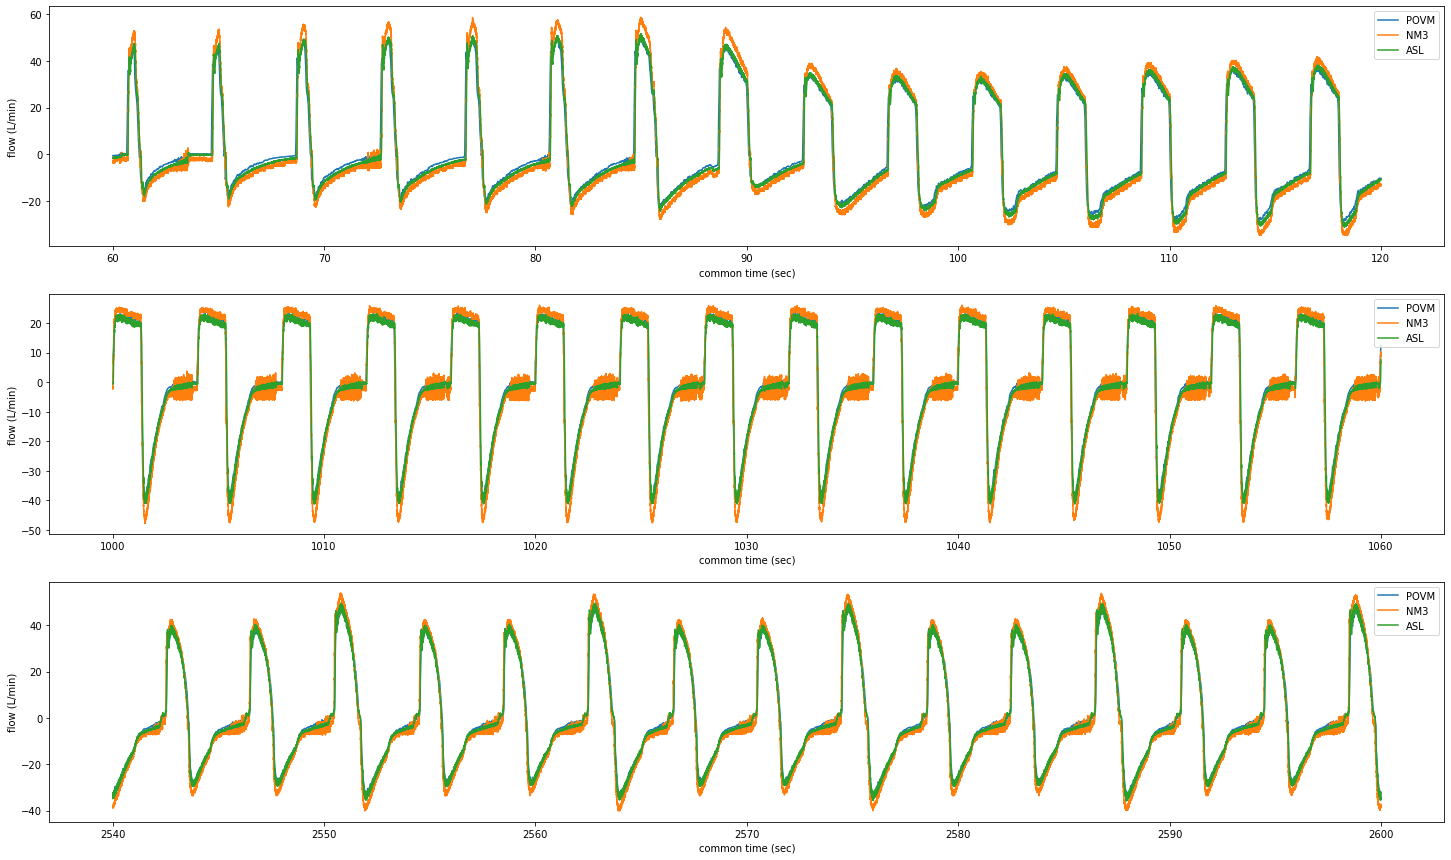

In [10]:
nm3_timeseries["time_shifted"] = nm3_timeseries["time (sec)"] - 39049.6    # tweaked by hand
asl_timeseries["time_shifted"] = asl_timeseries["Time (sec)"] - 1061.8     # tweaked by hand

def plot_in_window(ax, low, high):
    our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "flow (L/min)", ax=ax)
    nm3_timeseries[(low < nm3_timeseries["time_shifted"]) & (nm3_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax)
    asl_timeseries[(low < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax)
    ax.legend(["POVM", "NM3", "ASL"], loc="upper right")
    ax.set_ylabel("flow (L/min)")
    ax.set_xlabel("common time (sec)")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
plot_in_window(ax1, 60, 120)
plot_in_window(ax2, 1000, 1060)
plot_in_window(ax3, 2540, 2600)

## Pressure comparisons

These require slight tweaks to the time offset—the flow-measuring and pressure-measuring devices are probably offset in the stream and therefore see features at different times (by a tenth of a second or so).

Of all of ASL's "pressure" measurements, "airway pressure" is the only one that's remotely shaped like what we're measuring (both POVM and NM3).

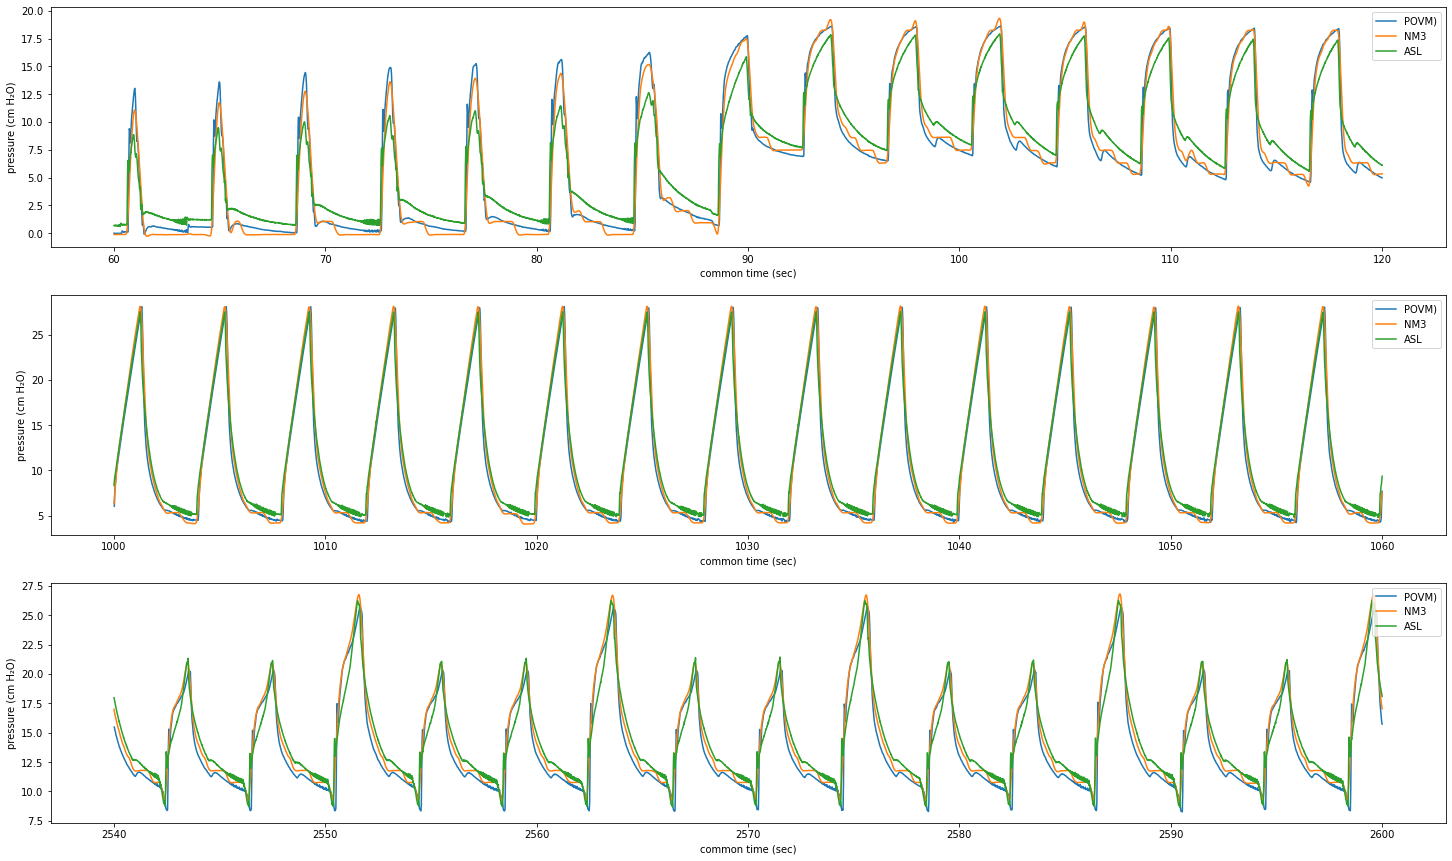

In [11]:
nm3_timeseries["time_shifted_pressure"] = nm3_timeseries["time_shifted"] - 0.2   # tweaked by hand
asl_timeseries["time_shifted_pressure"] = asl_timeseries["time_shifted"] - 0.1   # tweaked by hand

def plot_in_window(ax, low, high):
    our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "pressure (cm H2O)", ax=ax)
    nm3_timeseries[(low < nm3_timeseries["time_shifted_pressure"]) & (nm3_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "pressure (cm H20)", ax=ax)
    asl_timeseries[(low < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "Airway Pressure (cmH2O)", ax=ax)
    ax.legend(["POVM)", "NM3", "ASL"], loc="upper right")
    ax.set_ylabel("pressure (cm H₂O)")
    ax.set_xlabel("common time (sec)")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 15))
plot_in_window(ax1, 60, 120)
plot_in_window(ax2, 1000, 1060)
plot_in_window(ax3, 2540, 2600)

## Reproducing the flow plot in the paper (to replace it)

I have to find that time range again, and now the common time has a different offset.

This plot should replace the one in the paper because this one is derived from timeseries that were produced by the main codebase, not a random notebook. If we run `device_json_to_timeseries.py` again and re-evaluate this notebook, we can keep the following plot up to date.

In [12]:
asl_timeseries["volume (mL)"] = asl_timeseries["Total Volume (L)"] * 1000 * 1.12

In [13]:
our_color, nm3_color, asl_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

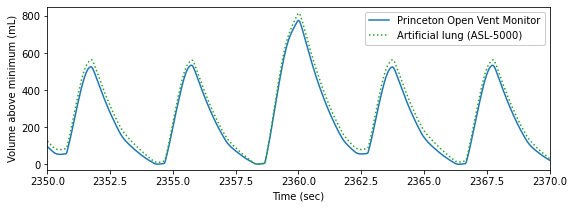

In [14]:
# low, high = 1135, 1155
low, high = 2350, 2370

our_timeseries["minbias_volume_shifted"] = our_timeseries["minbias volume (mL)"] - np.min(our_timeseries["minbias volume (mL)"][(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)])
asl_timeseries["volume_shifted"] = asl_timeseries["volume (mL)"] - np.min(asl_timeseries["volume (mL)"][(low < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high)])

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "minbias_volume_shifted", ax=ax, linewidth=1.5, c=our_color)
asl_timeseries[(low < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high)].plot("time_shifted", "volume_shifted", ax=ax, linewidth=1.5, linestyle=":", c=asl_color)
ax.legend(["Princeton Open Vent Monitor", "Artificial lung (ASL-5000)"], loc="upper right", framealpha=1)
ax.set_ylabel("Volume above minimum (mL)")
ax.set_xlabel("Time (sec)")
ax.set_xlim(low, high)
ax.set_ylim(-30, 850)
fig.savefig("../povm-nm3-asl-volume.pdf")

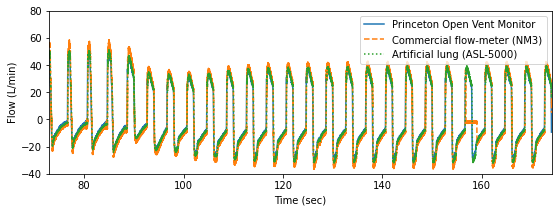

In [15]:
low, high = 73, 174

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "flow (L/min)", ax=ax, linewidth=1.5)
nm3_timeseries[(low < nm3_timeseries["time_shifted"]) & (nm3_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax, linewidth=1.5, linestyle="--")
asl_timeseries[(low < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < high)].plot("time_shifted", "flow (L/min)", ax=ax, linewidth=1.5, linestyle=":")
ax.legend(["Princeton Open Vent Monitor", "Commercial flow-meter (NM3)", "Artificial lung (ASL-5000)"], loc="upper right")
ax.set_ylabel("Flow (L/min)")
ax.set_xlabel("Time (sec)")
ax.set_xlim(low, high)
ax.set_ylim(-40, 80)
fig.savefig("../povm-nm3-asl.pdf")

## Matching time-window for pressure

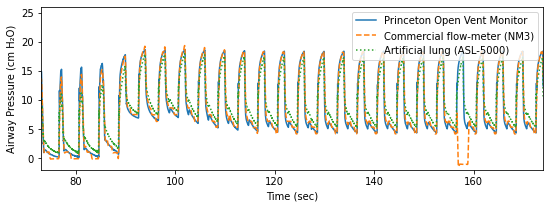

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
our_timeseries[(low < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < high)].plot("time (sec)", "pressure (cm H2O)", ax=ax, linewidth=1.5)
nm3_timeseries[(low < nm3_timeseries["time_shifted_pressure"]) & (nm3_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "pressure (cm H20)", ax=ax, linewidth=1.5, linestyle="--")
asl_timeseries[(low < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < high)].plot("time_shifted_pressure", "Airway Pressure (cmH2O)", ax=ax, linewidth=1.5, linestyle=":")
ax.legend(["Princeton Open Vent Monitor", "Commercial flow-meter (NM3)", "Artificial lung (ASL-5000)"], loc="upper right")
ax.set_ylabel("Airway Pressure (cm H₂O)")
ax.set_xlabel("Time (sec)")
ax.set_xlim(low, high)
ax.set_ylim(-2, 26)
fig.savefig("../povm-nm3-asl-pressure.pdf")

## Volume vs minbias volume

The "volume" is the volume that we've been showing on the GUI this whole time.

The "minbias volume" is a new calculation that has a 400× lower critical frequency (weaker high-pass filter), and this "minbias volume" is the one that is used to calculate volume _differences_, such as tidal volumes.

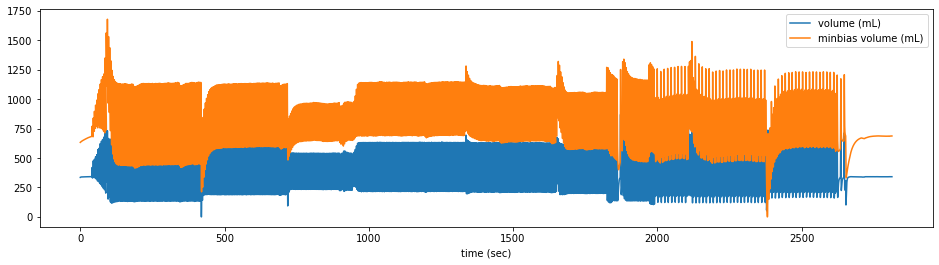

In [17]:
# The minbias volume drifts a lot more, so it's not appropriate to show on the GUI screen, but its shape is less distorted.

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

our_timeseries.plot("time (sec)", ["volume (mL)", "minbias volume (mL)"], ax=ax)
fig.savefig("/tmp/volume-vs-minbias-volume.png")

## Time since first breath in POVM

From Andy:

> Hi @Jim Pivarski Here are three time points i n he video, with mins and seconds elapsed since the first breath (which should be easy to detect on the POVM). I have pulled out derived quantities by reading off the screen of the ventilator in the video. The first point is for the ventulator under volume control. This is very regular.. each breath is the same. The second two time points are from synchronized pressure control. This one has variability in tidal volume and PIP from one breath to the next, so it may be harder to compare.
> 
> 1:50 s in video is first breath of ventilator.. should be first breath in recording
> 0m 0 s post first breath
> 
> 23 m 04 s in Video
> 21 m 14 s post first breath: under volume control; PEEP 5; Ppeak (PIP?) 29 cm H20; TV 500 mL, RR 15 bpm
> 
> 37 m 45 s in Video
> 35 m 55 s post first breath: under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 16 cmH20 [jumps back and forth between 23ish and 16ish]; TVexp 527 [jummps back and forth between 530ish and 700 ish3] ml; RR not reported.
> 
> 40m 32s in Video
> 38m 42s post first breath:  under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 21 cmH20; TVexp 507ml; RR not reported (edited) 
> 
> 9:30
> could you see what the values are that the POVM reports for these time points/

It looks like the "first breath" is at 40 seconds in the common time used by this analysis. There's 1‒2 seconds of uncertainty about what that means, and we could be off by one breath or so.

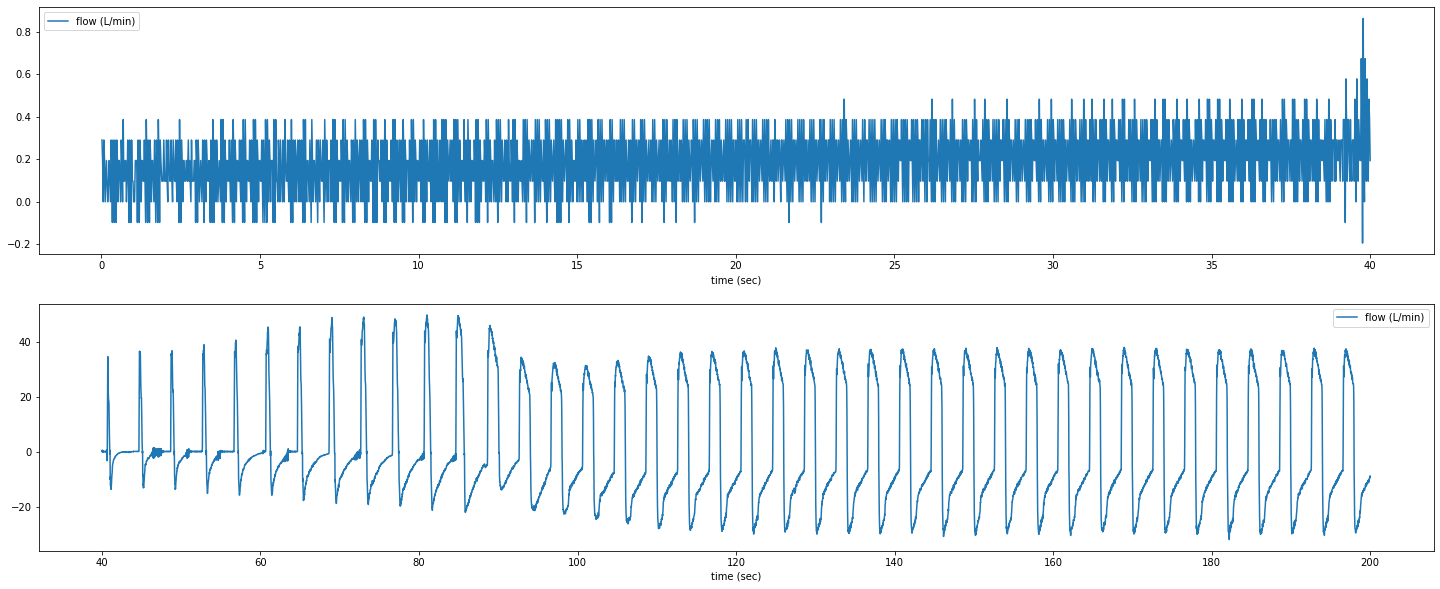

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))
our_timeseries[(0 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < 40)].plot("time (sec)", "flow (L/min)", ax=ax1)
our_timeseries[(40 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < 200)].plot("time (sec)", "flow (L/min)", ax=ax2)

In [19]:
our_breaths.iloc[:10]

,inhale timestamp (sec),inhale flow (L/min),inhale dV/dt (mL/sec),inhale dP/dt (cm H2O/sec),inhale compliance (ml/cm H2O),min pressure (cm H2O),full timestamp (sec),full pressure (cm H2O),full volume (mL),expiratory tidal volume (mL),...,exhale dP/dT (cm H2O/sec),exhale compliance (ml/cm H2O),max pressure (cm H2O),empty timestamp (sec),empty pressure (cm H2O),empty volume (mL),exhale time (sec),average flow (L/min),average pressure (cm H2O),time since last (sec)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,40.304000,-0.1812,684.1496,NaN,NaN,NaN,NaN
1,40.764000,34.7643,143.044867,2.580221,55.438997,NaN,41.044000,0.5228,768.4770,84.3274,...,-1.536830,68.318962,7.8072,44.305000,-0.5316,680.5836,3.261000,0.184030,-0.236357,4.001000
2,44.825000,34.6703,278.890419,4.670678,59.710912,-1.2160,45.185000,-1.3128,829.8532,149.2696,...,-1.552648,69.734822,8.4128,48.307000,-0.1457,727.4864,3.122000,1.123753,0.321197,4.002000
3,48.847044,36.9575,299.799024,3.662988,81.845475,-0.6198,49.187067,-0.7789,887.3416,159.8552,...,-1.872082,65.455667,9.2216,52.289000,0.0897,753.3311,3.101933,0.958570,0.633443,3.982000
4,52.869078,39.1641,346.319899,1.829615,189.285668,-0.2836,53.229844,-0.4096,939.2876,185.9565,...,-2.326864,62.789128,10.3067,56.295900,0.3653,772.8681,3.066056,0.978593,1.016081,4.006900
5,56.876000,39.4012,385.743090,5.874595,65.662929,-0.1229,57.256000,0.1094,982.6264,209.7583,...,-2.271882,73.929406,11.2895,60.316000,-0.0371,757.4496,3.060000,0.508262,1.162010,4.020100
6,60.916433,42.4237,486.418459,7.015952,69.330357,-0.0576,61.316878,2.3569,1041.3046,283.8550,...,-2.591990,71.843553,13.0307,64.297000,0.5559,782.9947,2.980122,1.211095,1.710886,3.981000
7,64.917000,42.4396,503.413899,4.802724,104.818407,0.0558,65.337000,2.3766,1076.1009,293.1062,...,-2.076558,101.133903,13.6087,68.361000,0.0590,759.1975,3.024000,0.533649,1.836963,4.064000
8,68.961000,46.4123,591.717397,5.487755,107.825043,0.0330,69.401000,2.9271,1123.0936,363.8961,...,-2.609470,88.283481,14.4498,72.361122,0.1330,760.6121,2.960122,0.976065,2.301748,4.000122
9,72.981833,47.9799,630.500570,4.497520,140.188485,0.1141,73.442111,3.0334,1158.5517,397.9396,...,-2.749520,88.571667,14.9065,76.364822,0.2244,753.7814,2.922711,0.900316,2.677545,4.003700


In [20]:
our_breaths["time@full"] = our_breaths["full timestamp (sec)"]
our_breaths["PIP"] = our_breaths["max pressure (cm H2O)"]
our_breaths["PEEP"] = our_breaths["empty pressure (cm H2O)"]
our_breaths["TVi"] = our_breaths["inspiratory tidal volume (mL)"]
our_breaths["TVe"] = our_breaths["expiratory tidal volume (mL)"]
our_breaths["I:E"] = our_breaths["inhale time (sec)"] / our_breaths["exhale time (sec)"]
our_breaths["RR"] = 60 / our_breaths["time since last (sec)"]

In [21]:
def plot_everything(central_value):
    our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["exhale timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["full timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["empty timestamp (sec)"])) &
                                       ((our_breaths["inhale timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["exhale timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["full timestamp (sec)"] < central_value + 10) |
                                        (our_breaths["empty timestamp (sec)"] < central_value + 10))]

    our_timeseries["volume_shifted"] = our_timeseries["volume (mL)"] - np.min(our_timeseries["volume (mL)"][(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)])
    our_timeseries["minbias_volume_shifted"] = our_timeseries["minbias volume (mL)"] - np.min(our_timeseries["minbias volume (mL)"][(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)])
    asl_timeseries["volume_shifted"] = asl_timeseries["volume (mL)"] - np.min(asl_timeseries["volume (mL)"][(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 10)])
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "volume_shifted", ax=ax1, label="POVM")
    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "minbias_volume_shifted", ax=ax1, label="POVM minbias")
    asl_timeseries[(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 10)].plot("time_shifted", "volume_shifted", ax=ax1, linewidth=1.5, linestyle=":", label="ASL")

    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "flow (L/min)", ax=ax2, linewidth=1.5, label="POVM")
    nm3_timeseries[(central_value - 10 < nm3_timeseries["time_shifted"]) & (nm3_timeseries["time_shifted"] < central_value + 10)].plot("time_shifted", "flow (L/min)", ax=ax2, linewidth=1.5, linestyle="--", label="NM3")
    asl_timeseries[(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 10)].plot("time_shifted", "flow (L/min)", ax=ax2, linewidth=1.5, linestyle=":", label="ASL")

    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 10)].plot("time (sec)", "pressure (cm H2O)", ax=ax3, linewidth=1.5, label="POVM")
    nm3_timeseries[(central_value - 10 < nm3_timeseries["time_shifted_pressure"]) & (nm3_timeseries["time_shifted_pressure"] < central_value + 10)].plot("time_shifted_pressure", "pressure (cm H20)", ax=ax3, linewidth=1.5, linestyle="--", label="NM3")
    asl_timeseries[(central_value - 10 < asl_timeseries["time_shifted_pressure"]) & (asl_timeseries["time_shifted_pressure"] < central_value + 10)].plot("time_shifted_pressure", "Airway Pressure (cmH2O)", ax=ax3, linewidth=1.5, linestyle=":", label="ASL")

    for i in range(len(our_breaths_relevant)):
        for ax in (ax1, ax2, ax3):
            ax.axvline(our_breaths_relevant["full timestamp (sec)"].values[i], c="red")
            ax.axvline(our_breaths_relevant["exhale timestamp (sec)"].values[i], c="orange")
            ax.axvline(our_breaths_relevant["empty timestamp (sec)"].values[i], c="green")
    ax1.grid(axis="y")
    ax2.grid(axis="y")
    ax3.grid(axis="y")
#     ax1.set_ylim(0, 1000)
    ax2.set_ylim(-50, 60)
    ax3.set_ylim(0, 40)
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper right")
    ax3.legend(loc="upper right")
    ax1.set_xlabel("time (sec)")
    ax2.set_xlabel("time (sec)")
    ax3.set_xlabel("time (sec)")
    ax1.set_ylabel("volume (mL)")
    ax2.set_ylabel("flow (L/min)")
    ax3.set_ylabel("pressure (cm H₂O)")

    return our_breaths_relevant[["time@full", "PIP", "PEEP", "TVi", "TVe", "I:E", "RR"]]

In [22]:
def plot_volumes(central_value):
    our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["exhale timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["full timestamp (sec)"]) |
                                        (central_value - 10 < our_breaths["empty timestamp (sec)"])) &
                                       ((our_breaths["inhale timestamp (sec)"] < central_value + 5) |
                                        (our_breaths["exhale timestamp (sec)"] < central_value + 5) |
                                        (our_breaths["full timestamp (sec)"] < central_value + 5) |
                                        (our_breaths["empty timestamp (sec)"] < central_value + 5))]

    our_timeseries["volume_shifted"] = our_timeseries["volume (mL)"] - np.min(our_timeseries["volume (mL)"][(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 5)])
    our_timeseries["minbias_volume_shifted"] = our_timeseries["minbias volume (mL)"] - np.min(our_timeseries["minbias volume (mL)"][(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 5)])
    asl_timeseries["volume_shifted"] = (asl_timeseries["volume (mL)"] - np.min(asl_timeseries["volume (mL)"][(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 5)]))
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(16, 4))
#     our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 5)].plot("time (sec)", "volume_shifted", ax=ax1, label="POVM")
    our_timeseries[(central_value - 10 < our_timeseries["time (sec)"]) & (our_timeseries["time (sec)"] < central_value + 5)].plot("time (sec)", "minbias_volume_shifted", ax=ax1, label="POVM minbias")
    asl_timeseries[(central_value - 10 < asl_timeseries["time_shifted"]) & (asl_timeseries["time_shifted"] < central_value + 5)].plot("time_shifted", "volume_shifted", ax=ax1, linewidth=1.5, linestyle=":", label=f"ASL \u00d7 1.12")

    ax1.grid(axis="y")
    ax1.legend(loc="upper right")
    ax1.set_xlabel("time (sec)")
    ax1.set_ylabel("volume (mL)")
    
    return fig

### First comparison

> 23 m 04 s in Video 21 m 14 s post first breath: under volume control; PEEP 5; Ppeak (PIP?) 29 cm H20; TV 500 mL, RR 15 bpm

,time@full,PIP,PEEP,TVi,TVe,I:E,RR
317,1305.085456,28.0216,4.4367,441.3827,440.0749,0.662777,15.020277
318,1309.091022,27.9562,4.5021,446.0207,444.4002,0.673305,15.059149
319,1313.080000,28.0412,4.5493,433.5316,434.4526,0.669954,14.970475
320,1317.080000,28.0105,4.4863,437.3303,435.3759,0.672269,15.075377
321,1321.074000,28.0239,4.4430,436.1067,434.5045,0.672500,14.947683


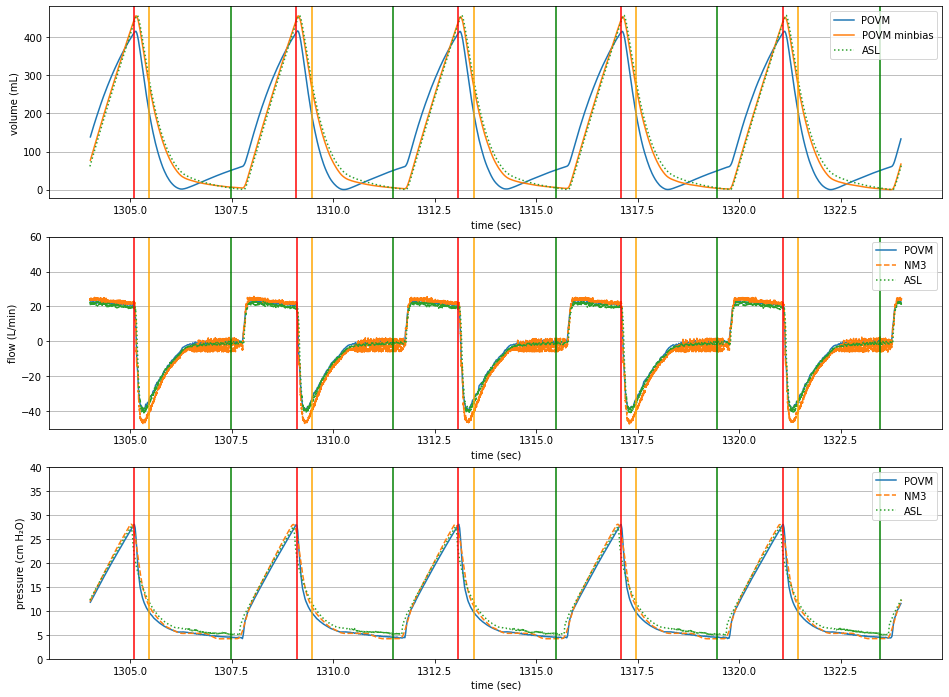

In [23]:
plot_everything(40 + 21*60 + 14)

In [24]:
central_value = 40 + 21*60 + 14

our_breaths_relevant = our_breaths[((central_value - 10 < our_breaths["inhale timestamp (sec)"]) |
                                    (central_value - 10 < our_breaths["exhale timestamp (sec)"]) |
                                    (central_value - 10 < our_breaths["full timestamp (sec)"]) |
                                    (central_value - 10 < our_breaths["empty timestamp (sec)"])) &
                                   ((our_breaths["inhale timestamp (sec)"] < central_value + 10) |
                                    (our_breaths["exhale timestamp (sec)"] < central_value + 10) |
                                    (our_breaths["full timestamp (sec)"] < central_value + 10) |
                                    (our_breaths["empty timestamp (sec)"] < central_value + 10))]

our_breaths_relevant[["PIP", "PEEP", "TVi", "TVe", "I:E", "RR"]].mean()

PIP      28.010680
PEEP      4.483480
TVi     438.874400
TVe     437.761620
I:E       0.670161
RR       15.014592
dtype: float64

**expecting** PEEP 5; Ppeak (PIP?) 29 cm H20; TV 500 mL, RR 15 bpm

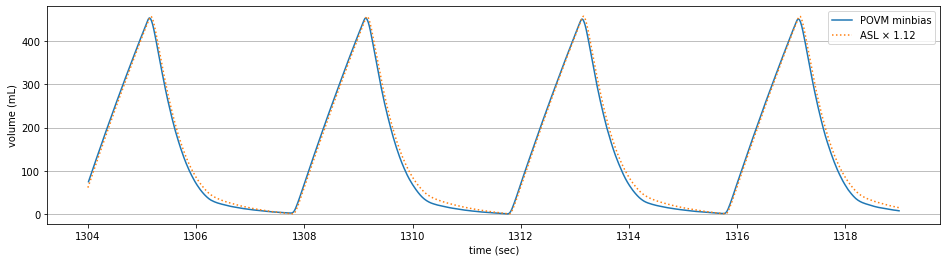

In [25]:
fig = plot_volumes(40 + 21*60 + 14)
fig.savefig("/tmp/minbias-volume.png")

### Second comparison

> 37 m 45 s in Video
> 35 m 55 s post first breath: under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 16 cmH20 [jumps back and forth between 23ish and 16ish]; TVexp 527 [jummps back and forth between 530ish and 700 ish3] ml; RR not reported.

,time@full,PIP,PEEP,TVi,TVe,I:E,RR
563,2295.738256,20.1127,10.2603,529.6099,530.3552,0.510583,15.120333
564,2299.975000,24.3423,10.0169,720.0549,773.7839,0.637558,14.510863
565,2303.724233,20.1135,10.3666,521.3916,468.9054,0.459264,15.424649
566,2307.737122,20.1229,10.2831,531.8352,532.2482,0.511687,15.074661
567,2311.974000,24.3353,10.2280,712.6554,766.9670,0.640321,14.602725


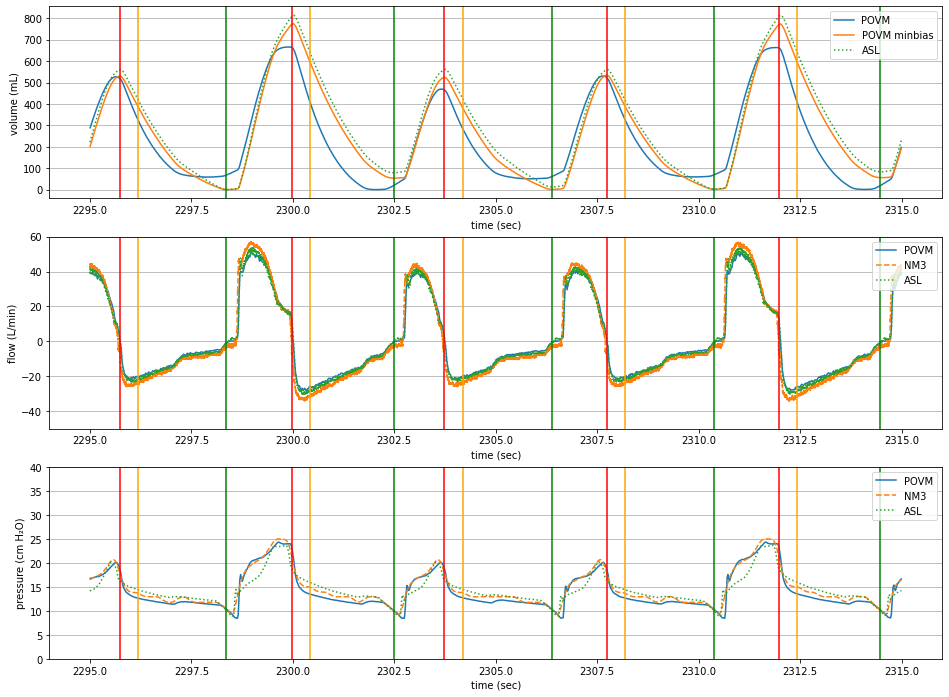

In [26]:
plot_everything(40 + 37*60 + 45)

### Third comparison

> 40m 32s in Video
> 38m 42s post first breath:  under Synchronized pressure control; PEEP 5; Ppeak (PIP?) 21 cmH20; TVexp 507ml; RR not reported

,time@full,PIP,PEEP,TVi,TVe,I:E,RR
577,2351.736000,20.1379,10.0894,525.3330,472.5160,0.465633,15.355567
578,2355.742000,20.1229,10.2319,533.3876,533.7202,0.510472,15.132324
579,2359.969000,24.3447,9.9508,718.9024,773.3558,0.635411,14.552000
580,2363.733456,20.1300,10.2555,524.5668,469.2549,0.468918,15.405595
581,2367.731544,20.1355,10.2729,534.4464,533.5385,0.511571,15.078618
582,2371.964433,24.3549,10.0540,722.8808,775.7122,0.634019,14.546512


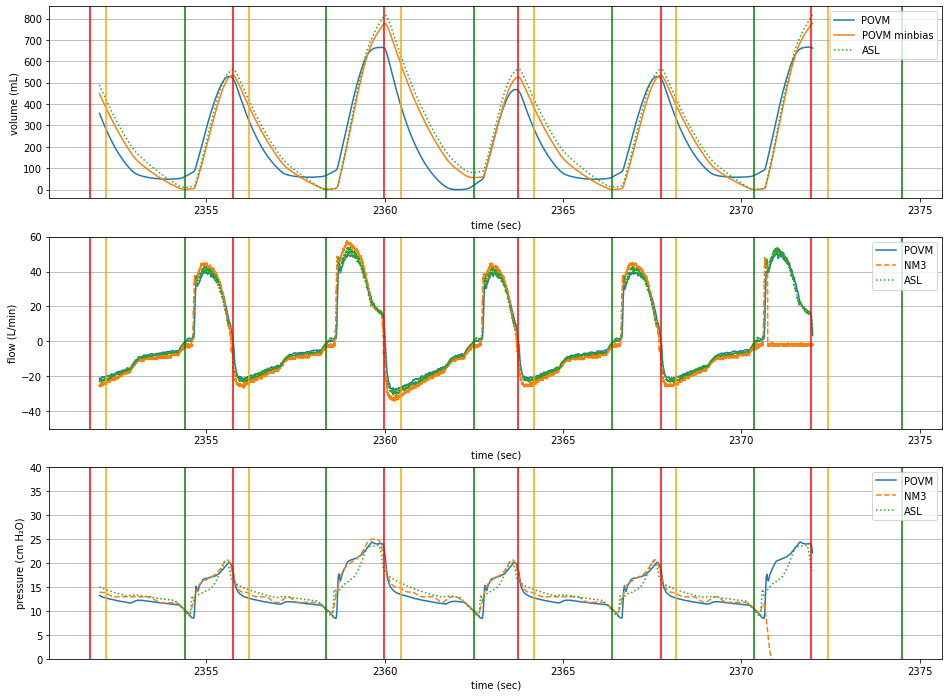

In [27]:
plot_everything(40 + 38*60 + 42)

### Another data point

> Hi @Jim Pivarski at 20 mins 15 s in the video (18m 35s post-first-breath the NM3s report a Vte of 468 and 460). We can report those in the table.

,time@full,PIP,PEEP,TVi,TVe,I:E,RR
277,1145.196000,28.1098,4.5202,436.2754,434.2316,0.665599,14.984641
278,1149.200300,28.0924,4.5422,444.5145,443.0938,0.671884,15.067385
279,1153.205000,28.0184,4.5241,435.6523,439.4851,0.680742,14.974211
280,1157.189056,28.0932,4.4895,442.3880,440.8298,0.666428,14.996251
281,1161.190611,28.0948,4.4950,442.9287,443.1425,0.671288,15.056462
282,1165.195000,28.0011,4.4934,447.3559,443.5647,0.680672,15.000000


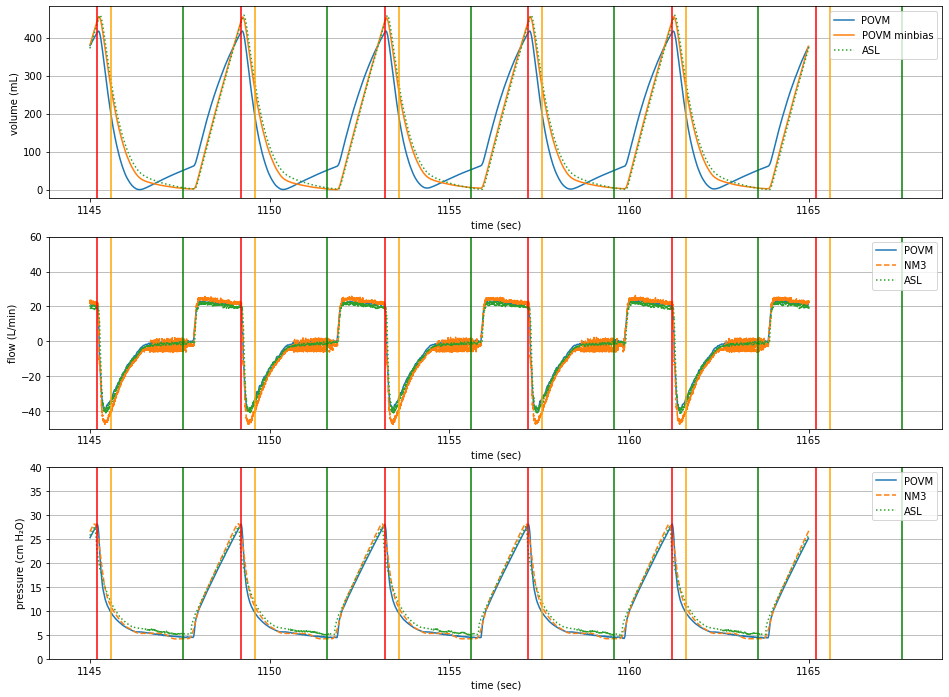

In [28]:
plot_everything(40 + 18*60 + 35)

## Common time-bins between POVM and NM3 to make the scatter plots

In [29]:
our_timeseries

,time (sec),pressure (cm H2O),flow (L/min),volume (mL),minbias volume (mL),minbias_volume_shifted,volume_shifted
0,0.000,-0.2040,-0.0971,335.3869,632.2089,-56.6370,121.0090
1,0.020,-0.1749,0.2904,335.4189,632.2411,-56.6048,121.0410
2,0.040,-0.1615,0.1939,335.4987,632.3217,-56.5242,121.1208
3,0.060,-0.1962,0.0000,335.5294,632.3539,-56.4920,121.1515
4,0.080,-0.1898,0.2904,335.5758,632.4021,-56.4438,121.1979
...,...,...,...,...,...,...,...
140440,2813.227,-0.0410,0.3865,340.9751,686.5913,-2.2546,126.5972
140441,2813.247,-0.0371,0.1939,341.0014,686.6197,-2.2262,126.6235
140442,2813.267,-0.0615,0.0000,340.9634,686.5837,-2.2622,126.5855
140443,2813.287,-0.0142,0.3865,340.9578,686.5798,-2.2661,126.5799


In [30]:
nm3_timeseries

,time (sec),pressure (cm H20),flow (L/min),time_shifted,time_shifted_pressure
0,39078.5764,-1.165036,-2.176782,28.9764,28.7764
1,39078.5774,-1.165036,-2.073890,28.9774,28.7774
2,39078.5784,-1.165036,-2.365417,28.9784,28.7784
3,39078.5794,-1.165036,-2.108187,28.9794,28.7794
4,39078.5804,-1.165036,-1.816660,28.9804,28.7804
...,...,...,...,...,...
2720995,41799.5714,-0.142530,-1.885255,2749.9714,2749.7714
2720996,41799.5724,-0.142530,-2.125336,2749.9724,2749.7724
2720997,41799.5734,-0.142530,-2.622647,2749.9734,2749.7734
2720998,41799.5744,-0.142530,-2.176782,2749.9744,2749.7744


In [55]:
def common_flow(flow_time_offset):
    flow_bins = np.arange(50, 2750, 0.1)

    ourtime_fit = our_timeseries["time (sec)"].values - our_timeseries["time (sec)"].values[0] + flow_time_offset
    ourflow_fit = our_timeseries["flow (L/min)"].values
    nm3time_fit = nm3_timeseries["time (sec)"].values - nm3_timeseries["time (sec)"].values[0]
    nm3flow_fit = nm3_timeseries["flow (L/min)"].values

    ourindex = np.digitize(ourtime_fit, flow_bins)
    ourflow_numer = np.zeros(len(flow_bins) + 1, np.float64)
    ourflow_denom = np.zeros(len(flow_bins) + 1, np.float64)
    ourflow_binned = np.zeros(len(flow_bins) + 1, np.float64)
    np.add.at(ourflow_numer, ourindex, ourflow_fit)
    np.add.at(ourflow_denom, ourindex, 1)
    np.true_divide(ourflow_numer, ourflow_denom, out=ourflow_binned, where=(ourflow_denom != 0))

    nm3index = np.digitize(nm3time_fit, flow_bins)
    nm3flow_numer = np.zeros(len(flow_bins) + 1, np.float64)
    nm3flow_denom = np.zeros(len(flow_bins) + 1, np.float64)
    nm3flow_binned = np.zeros(len(flow_bins) + 1, np.float64)
    np.add.at(nm3flow_numer, nm3index, nm3flow_fit)
    np.add.at(nm3flow_denom, nm3index, 1)
    np.true_divide(nm3flow_numer, nm3flow_denom, out=nm3flow_binned, where=(nm3flow_denom != 0))

    return flow_bins, ourflow_binned[:-1], nm3flow_binned[:-1]

In [56]:
def flowchi2(flow_time_offset=-29.0):
    t, x, y = common_flow(flow_time_offset)
    return np.sum((x - y)**2)

flowminuit = iminuit.Minuit(flowchi2, flow_time_offset=-29.0, error_flow_time_offset=0.1, errordef=1)
flowminuit.migrad()

------------------------------------------------------------------
| FCN = 5.391E+05               |      Ncalls=63 (74 total)      |
| EDM = 2.2E+09 (Goal: 0.0002)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   False   |  True  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------------------
|   | Name             |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------------------
| 0 | flow_time_offset |   -29.0   |    1.4    |            |            |         |         |       |
------------------------------------------------------------------------------------------------------

In [57]:
flowminuit.values

<ValueView of Minuit at 55e00385fe10>
  flow_time_offset: -28.973256540530357

In [58]:
flowminuit.errors

<ErrorView of Minuit at 55e00385fe10>
  flow_time_offset: 1.4142135623730951

In [59]:
flow_bins, ourflow_binned, nm3flow_binned = common_flow(flowminuit.values["flow_time_offset"])

In [64]:
def common_pressure(pressure_time_offset):
    pressure_bins = np.arange(50, 2750, 0.1)

    ourtime_fit = our_timeseries["time (sec)"].values - our_timeseries["time (sec)"].values[0] + pressure_time_offset
    ourpressure_fit = our_timeseries["pressure (cm H2O)"].values
    nm3time_fit = nm3_timeseries["time (sec)"].values - nm3_timeseries["time (sec)"].values[0]
    nm3pressure_fit = nm3_timeseries["pressure (cm H20)"].values

    ourindex = np.digitize(ourtime_fit, pressure_bins)
    ourpressure_numer = np.zeros(len(pressure_bins) + 1, np.float64)
    ourpressure_denom = np.zeros(len(pressure_bins) + 1, np.float64)
    ourpressure_binned = np.zeros(len(pressure_bins) + 1, np.float64)
    np.add.at(ourpressure_numer, ourindex, ourpressure_fit)
    np.add.at(ourpressure_denom, ourindex, 1)
    np.true_divide(ourpressure_numer, ourpressure_denom, out=ourpressure_binned, where=(ourpressure_denom != 0))

    nm3index = np.digitize(nm3time_fit, pressure_bins)
    nm3pressure_numer = np.zeros(len(pressure_bins) + 1, np.float64)
    nm3pressure_denom = np.zeros(len(pressure_bins) + 1, np.float64)
    nm3pressure_binned = np.zeros(len(pressure_bins) + 1, np.float64)
    np.add.at(nm3pressure_numer, nm3index, nm3pressure_fit)
    np.add.at(nm3pressure_denom, nm3index, 1)
    np.true_divide(nm3pressure_numer, nm3pressure_denom, out=nm3pressure_binned, where=(nm3pressure_denom != 0))
    
    return pressure_bins, ourpressure_binned[:-1], nm3pressure_binned[:-1]

In [65]:
def pressurechi2(pressure_time_offset=-28.9):
    t, x, y = common_pressure(pressure_time_offset)
    return np.sum((x - y)**2)

pressureminuit = iminuit.Minuit(pressurechi2, pressure_time_offset=-29.0, error_pressure_time_offset=0.1, errordef=1)
pressureminuit.migrad()

------------------------------------------------------------------
| FCN = 9.235E+04               |      Ncalls=34 (42 total)      |
| EDM = 4.46 (Goal: 0.0002)     |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------
|   | Name                 |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
----------------------------------------------------------------------------------------------------------
| 0 | pressure_time_offset | -2.877E1  |  0.000E1  |            |            |         |         |       |
----------------------------------------------------------------------------------------------------------

In [66]:
pressureminuit.values

<ValueView of Minuit at 55e007e46390>
  pressure_time_offset: -28.769389506961993

In [67]:
pressureminuit.errors

<ErrorView of Minuit at 55e007e46390>
  pressure_time_offset: 0.000153875179009314

In [68]:
pressure_bins, ourpressure_binned, nm3pressure_binned = common_pressure(pressureminuit.values["pressure_time_offset"])

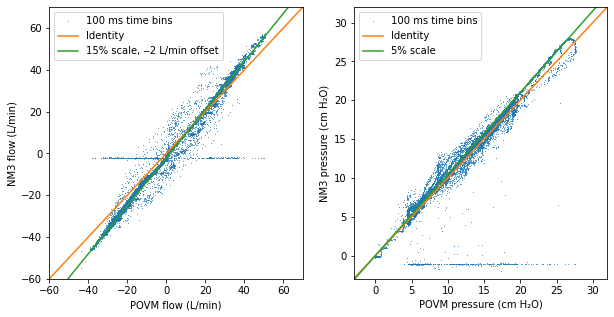

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(ourflow_binned, nm3flow_binned, "o", markeredgewidth=0, markersize=0.75)
ax1.set_xlim(-60, 70)
ax1.set_ylim(-60, 70)
ax1.plot([-60, 70], [-60, 70])
factor = 1.15; shift = -2; ax1.plot([-60, 70], [-60*factor + shift, 70*factor + shift])
ax1.set_xlabel("POVM flow (L/min)")
ax1.set_ylabel("NM3 flow (L/min)")
ax1.legend(["100 ms time bins", "Identity", "15% scale, \u20122 L/min offset"], loc="upper left")

ax2.plot(ourpressure_binned, nm3pressure_binned, "o", markeredgewidth=0, markersize=0.75)
ax2.set_xlim(-3, 32)
ax2.set_ylim(-3, 32)
ax2.plot([-3, 32], [-3, 32])
factor = 1.05; ax2.plot([-3, 32], [-3*factor, 32*factor])
ax2.set_xlabel("POVM pressure (cm H₂O)")
ax2.set_ylabel("NM3 pressure (cm H₂O)")
ax2.legend(["100 ms time bins", "Identity", "5% scale"], loc="upper left")

fig.savefig("povm-nm3-comparison.png", dpi=1000)